<hr style="border:2px solid #0281c9"> </hr>

<img align="left" alt="ESO Logo" src="http://archive.eso.org/i/esologo.png">  

<div align="center">
  <h1 style="color: #0281c9; font-weight: bold;">ESO Science Archive</h1> 
  <h2 style="color: #0281c9; font-weight: bold;">Jupyter Notebooks</h2>
</div>

<hr style="border:2px solid #0281c9"> </hr>

# **Query by Source Name (position) and Examine Spectral Data as function of time**

This notebook guides users on how to query science-ready spectral databases from ESO, filter the desired observations, and perform cutouts of specific spectral regions before downloading the data. It provides an example science case focusing on creating a spectral sequence for the well-known Beta Pictoris system. The presence of exo-comets is inferred from the stochastic appearances and disappearances of narrow absorption components in gas tracers such as Calcium, caused by the sublimated gas tails of the comets eclipsing our line of sight towards the star.

In addition to querying and downloading data, this notebook also demonstrates how to visualize the spectra and create animated GIFs to illustrate spectral changes over time. The GIFs provide dynamic views of the spectral data, including both cumulative and non-cumulative perspectives, enhancing the analysis of temporal variations.

--- 
**Author**: Catalina Sáez Carvajal (modified by Ashley Thomas Barnes)
<hr style="border:2px solid #0281c9"> </hr>

# **Importing and basic usage of astroquery.eso**

In [1]:
import astroquery # import astroquery
print(f"astroquery version: {astroquery.__version__}") # check the version of astroquery

astroquery version: 0.4.11.dev10290


In [2]:
from astroquery.eso import Eso # import the ESO module from astroquery

In [3]:
eso = Eso() # create an instance of the ESO class 

In [4]:
# Numerical and Data Handling
import numpy as np  # Numerical operations and array handling
import pandas as pd  # Data manipulation and analysis

# Astronomy and Astropy Core
import astropy.units as u  # Physical units and quantities
import astropy.constants as const  # Physical constants (e.g., c, G, h)
from astropy.io import fits  # Reading and writing FITS files
from astropy.coordinates import SkyCoord  # Celestial coordinate handling and transformations
from astropy.time import Time  # Time conversion and formatting (e.g., Julian Date, ISO)

# Visualization
import matplotlib.pyplot as plt  # Core plotting library
from matplotlib.animation import FuncAnimation, PillowWriter  # Animation tools for dynamic plots

# Coronagraph Simulation
import coronagraph as cg  # Tools for modeling coronagraph instrument performance

# Stop Warnings 
import warnings  # Standard Python module for issuing warnings
warnings.filterwarnings("ignore")  # Ignore all warnings, useful for cleaner output in notebooks or scripts

**Note:** In the above, we import a relatively non-standard module `coronagraph` but this can be easily intalled with the following:
```bash
pip install coronagraph
```
Also note that this will fail to import for SciPy > `1.12.0` so run the following if getting an error. 
```bash
pip install scipy==1.11.4
```

In [5]:
# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200

# **Performing a Small Cone Search Around Target**

In this example, we are interested in finding datasets within 5 arcseconds of **Beta Pictoris**, making a cone search particularly useful. You can either use the object's equatorial coordinates directly or employ a name resolver like SESAME (from CDS) to retrieve them. This defines a circular search region characterized by three parameters: right ascension (RA), declination (Dec), and radius, all expressed in degrees.


In [6]:
star_name = 'Beta Pictoris'
coords_BetaPec = SkyCoord.from_name(star_name)

radius = 5 *u.arcsec # Radius of the search area

Define the current date and time to get only currently public observations (i.e. with `obs_release_date` later than now).

In [7]:
now = Time.now() # Get the current time
now = str(now.datetime64.astype('datetime64[s]')) # Convert to datetime64 format

Now, to look for a given reduced dataset, we perform the cone search intersecting a circle of 5 arcseconds around our target. The query is written in ADQL (Astronomical Data Query Language).

In this query we specify:
- **Radius (``radius``)**: Filtering of 5 arcsec around position 
- **Spectral Resolving Power (`em_res_power`)**: Filtering datasets with a resolving power greater than 40000.
- **Data Product Type (`data_types`)**: Filtering for spectral data.
- **Spectral Bounds (`em_min` and `em_max`)**: Selecting spectra that cover the vacuum wavelength range expressed in meters. Note that here we include the `enclosed=False`, which states the condition will be `em_min < em_min` and `em_max > em_max`.
- **Signal to Noise Ratio (`snr`)**: Selecting datasets with SNR greater than 300.
- **Instrument Name (`instrument_name`)**: Restricting the search to objects observed by HARPS.
- **Top 10 Objects**: Selecting the top 10 objects with the highest SNR.

In [8]:
table = eso.query_surveys(column_filters={
                                        "instrument_name": "HARPS",
                                        "dataproduct_type": "spectrum",
                                        "em_min": "<3.933643e-07",
                                        "em_max": ">3.933683e-07",
                                        "snr": ">300",
                                        "em_res_power": ">40000", 
                                        "obs_release_date": f"<= '{now}'"},
                        cone_ra=coords_BetaPec.ra.value, 
                        cone_dec=coords_BetaPec.dec.value, 
                        cone_radius=radius.to("deg").value) 

In [9]:
table.sort(['instrument_name', 'dp_id'])
table["target_name", "instrument_name", "proposal_id", "obs_id", "obs_collection", "obstech", "dp_id"]

target_name,instrument_name,proposal_id,obs_id,obs_collection,obstech,dp_id
object,object,object,object,object,object,object
HD39060,HARPS,076.C-0279(A),13,HARPS,ECHELLE,ADP.2014-09-16T11:03:44.833
HD39060,HARPS,076.C-0279(A),16,HARPS,ECHELLE,ADP.2014-09-16T11:03:45.750
HD39060,HARPS,076.C-0279(A),16,HARPS,ECHELLE,ADP.2014-09-16T11:05:09.550
HD39060,HARPS,076.C-0279(A),13,HARPS,ECHELLE,ADP.2014-09-16T11:06:22.077
HD39060,HARPS,082.C-0412(A),17,HARPS,ECHELLE,ADP.2014-09-18T12:09:47.350
HD39060,HARPS,082.C-0412(A),15,HARPS,ECHELLE,ADP.2014-09-18T12:09:52.027
HD39060,HARPS,082.C-0412(A),15,HARPS,ECHELLE,ADP.2014-09-18T12:09:55.643
HD39060,HARPS,082.C-0412(A),15,HARPS,ECHELLE,ADP.2014-09-18T12:10:07.263
HD39060,HARPS,082.C-0412(A),15,HARPS,ECHELLE,ADP.2014-09-18T12:10:19.833


# **Downloading datasets from the archive**

In [10]:
data_files = eso.retrieve_data(table['dp_id'], destination='./data/') 

INFO: Downloading datasets ... [astroquery.eso.core]
INFO: Downloading 292 files ... [astroquery.eso.core]
INFO: Downloading file 1/292 https://dataportal.eso.org/dataPortal/file/ADP.2014-09-16T11:03:44.833 to /Users/abarnes/Library/CloudStorage/Dropbox/GitHub/astroquery_examples_eso/data [astroquery.eso.core]
INFO: Successfully downloaded dataset ADP.2014-09-16T11:03:44.833 to /Users/abarnes/Library/CloudStorage/Dropbox/GitHub/astroquery_examples_eso/data/ADP.2014-09-16T11:03:44.833.fits [astroquery.eso.core]
INFO: Downloading file 2/292 https://dataportal.eso.org/dataPortal/file/ADP.2014-09-16T11:03:45.750 to /Users/abarnes/Library/CloudStorage/Dropbox/GitHub/astroquery_examples_eso/data [astroquery.eso.core]
INFO: Successfully downloaded dataset ADP.2014-09-16T11:03:45.750 to /Users/abarnes/Library/CloudStorage/Dropbox/GitHub/astroquery_examples_eso/data/ADP.2014-09-16T11:03:45.750.fits [astroquery.eso.core]
INFO: Downloading file 3/292 https://dataportal.eso.org/dataPortal/file/ADP

---
# **Explore the data**

**Function: Spectra_parameters**

First, we define the function `Spectra_parameters`, which calculates spectral parameters using a reference wavelength (`ref`), a resolution (`R`), and a variable range (`var`). This function constructs the wavelength array, computes the corresponding velocities, and then saves the velocity data to a CSV file.


In [11]:
def Spectra_parameters(ref=3933.7, R=115000, var=20):
    """Calculate spectral parameters based on reference wavelength, resolution, and variable range
    
    Parameters:
    ref (int): Reference wavelength in nm (CaII K in the air expressed in Angstrom)
    R (int): Spectral resolution
    var (int): Variable range in nm

    Returns:
    wl (array): Wavelength array
    dwl (array): Wavelength step size
    velocity (array): Velocity array
    vel (DataFrame): DataFrame with velocities
    lammin (int): Minimum wavelength
    lammax (int): Maximum wavelength
    """

    # Define the wavelength range around the reference
    lammin = ref-var
    lammax = ref+var
    
    # Construct the wavelength array and wavelength step size using the coronagraph module
    c = const.c.to('km/s').value # Speed of light in km/s
    wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, R)
    velocity = c*((wl-ref)/wl) # Calculate the velocity for each wavelength
    vel = pd.DataFrame(data=velocity,columns=['Velocity']) # Create a DataFrame with the velocities
    vel.to_csv('./data/velocity.csv') #Save the velocity data to a CSV file
    
    return wl, dwl, velocity, vel, lammin, lammax

#Calculate spectral parameters
wl, dwl, velocity, vel, lammin, lammax = Spectra_parameters()

**Processing FITS Files and Plotting Spectra**

In this section, we process the FITS files that were previously downloaded. For each file, we open it, extract the spectral data from extension 1, normalize the flux, calculate the velocity, and generate a plot of the spectral data.

 The processed data is stored in a DataFrame for further analysis, while observation dates are recorded in a separate DataFrame.

In [12]:
for i in range(len(data_files)):

    # Construct the full path to the FITS file
    # file_name = f'{output_dir}/{result_from_queries[i]["dp_id"]}_TARGET_{int(em_min_cut*1e9)}-{int(em_max_cut*1e9)}.fits'
    file_name = data_files[i]

    hdulist = fits.open(file_name) # Open the FITS file
    scidata = hdulist[1].data # Bintable extension
    wave = scidata[0][0] # Wavelength data
    flux = scidata[0][1] # Flux data
    contf = flux[np.logical_and(wave > lammin, wave < lammax)] #Select fluxes within the wavelength range
    natwav = wave[np.logical_and(wave > lammin, wave < lammax)] # Select wavelengths within the range
    natf = contf/np.percentile(contf, 95) # Normalize the flux to the 95th percentile
    flr = cg.downbin_spec(natf, natwav, wl, dlam=dwl) # Downsample the spectrum 
    
    # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
    if i==0:
        # If this is the first iteration (i == 0), create a new DataFrame df to store the flux data.
        df = pd.DataFrame(data=flr, columns=[table[i]['dp_id']])
        # Create another DataFrame df2 to store the observation date (MJD) of the file.
        df2 = pd.DataFrame(data=[[table[i]['dp_id'],hdulist[0].header['MJD-OBS']]],columns=['dp_id', 'MJD'])
    
    else:
        # For subsequent iterations (i > 0), add the new flux data to the existing DataFrame df.
        df[table[i]['dp_id']] = flr
        
        # Add the new observation date to the existing DataFrame df2.
        df2.loc[i] = [table[i]['dp_id'], hdulist[0].header['MJD-OBS']]

## **Visualizing Spectra with a Static Plot**

To begin, we generate a static plot that displays the normalized flux as a function of velocity for all spectra in our dataset. For clarity, individual spectra are shown in grey, while the mean spectrum is highlighted in red to improve visualization and facilitate comparison.

First, we create a static plot showing the normalized flux versus velocity for all the spectra in our dataset. For clarity, we overlay individual spectra in grey and plot the mean spectrum in red to enhance visualization.

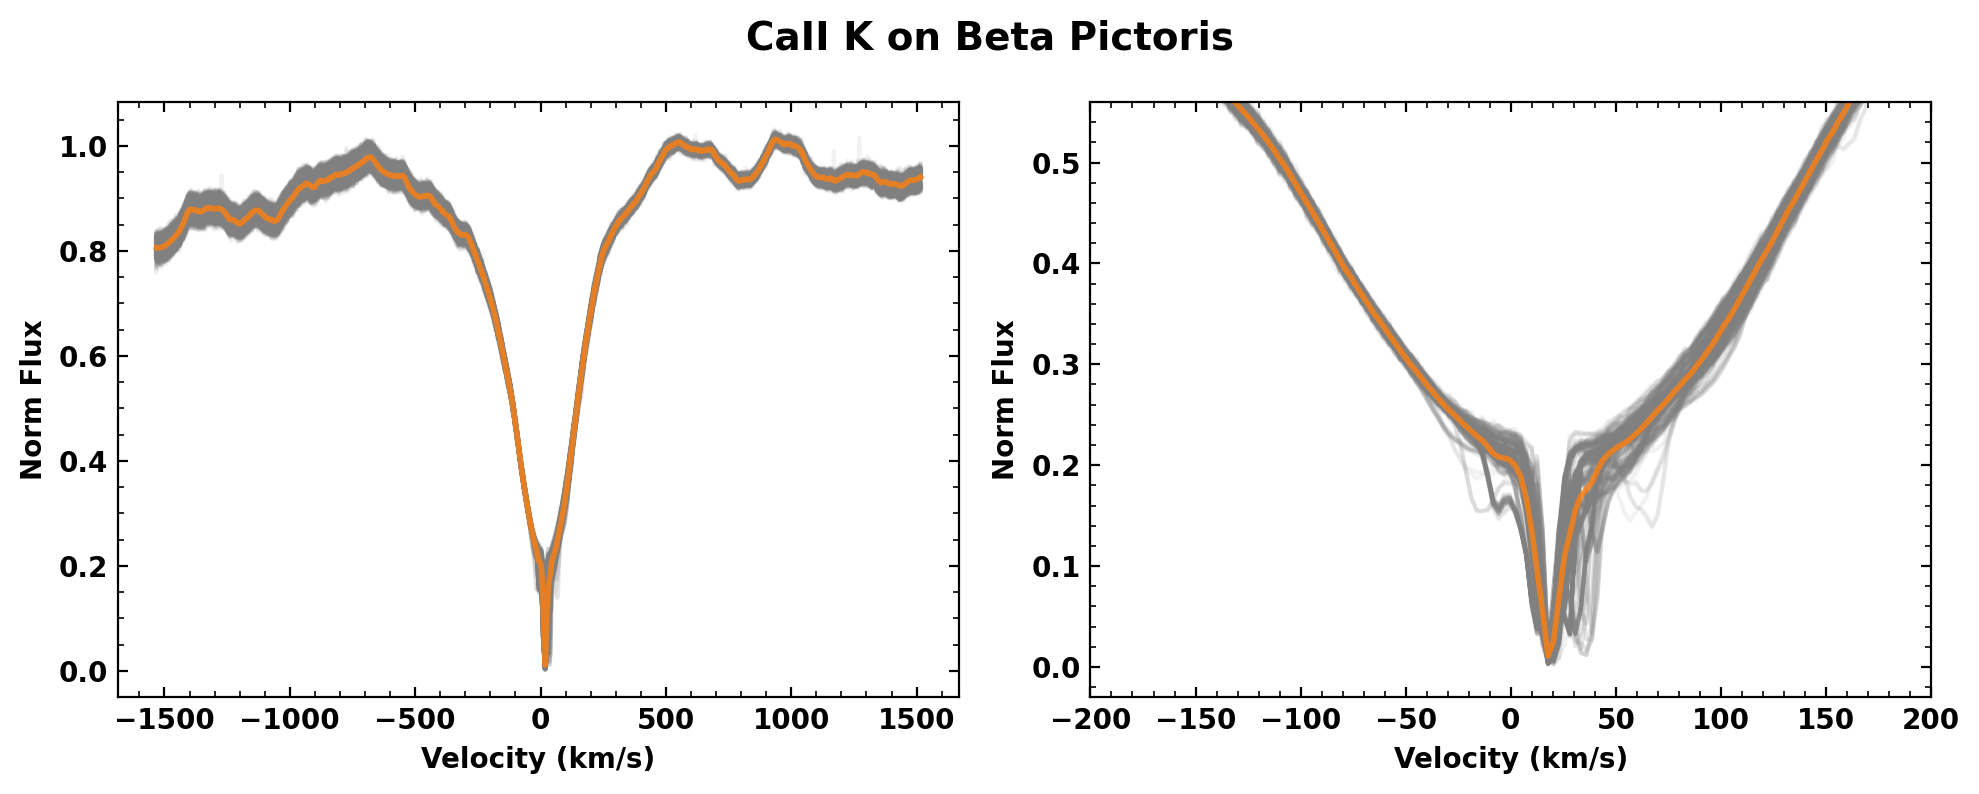

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

# Loop through each spectrum in the DataFrame df2
for i in range(df2.shape[0]):
    # Plot the normalized flux against velocity for each individual spectrum in grey with some transparency
    ax[0].plot(velocity,df[df2['dp_id'][i]].values, c='grey', alpha=0.1)
    ax[1].plot(velocity,df[df2['dp_id'][i]].values, c='grey', alpha=0.1)

# Plot the mean of all spectra in red with a slightly thicker line and reduced transparency to highlight it

ax[0].plot(velocity,df.mean(axis=1).values, color='C1', lw=2, alpha=0.8)
ax[0].set_xlabel('Velocity (km/s)')
ax[0].set_ylabel('Norm Flux')

ax[1].plot(velocity,df.mean(axis=1).values, color='C1', lw=2, alpha=0.8)
ax[1].set_xlabel('Velocity (km/s)')
ax[1].set_ylabel('Norm Flux')
ax[1].set_xlim(-200,200)
ax[1].set_ylim(-0.03,0.56)

fig.suptitle('CaII K on Beta Pictoris', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig('./figs/BetaPictoris_static.png', transparent=True)

## **Visualizing Spectra with a Animated Plot - Cumulative**

We create an animated GIF that visualizes cumulative spectral data over time. This animation allows us to observe how the spectral features evolve as new data is accumulated.

In [14]:
# Input MJD 
time_mjd = Time(df2['MJD'][0], format='mjd') # Convert MJD to Time object
time_mjd.datetime64.astype('datetime64[s]') # Convert to datetime64 format

numpy.datetime64('2006-02-09T02:30:17')

**Note:** The animation uses a significant amount of RAM (>2GB), and may take a while to generate. If you encounter issues, consider reducing the number of spectra or the resolution of the animation. This may also run into issues if you're running this script on e.g. mybinder.org, so you may want to run this locally. 

In [15]:
make_animation = False # Set to True to create the animation, False to skip - may use a lot of RAM

if make_animation:
    print("Creating animation... This may take a while, please be patient.")

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    # Add small subplot in corner 
    ax_sub = fig.add_axes([0.57, 0.2, 0.3, 0.3]) # [left, bottom, width, height]

    plt.suptitle('CaII K on Beta Pictoris', fontsize=14, fontweight='bold')

    nframes = df.shape[1] # Determine the number of frames based on the number of columns in the DataFrame
    # nframes = 10

    # Function to animate each frame
    def animate(i):

        # Plot the mean values of the DataFrame as a red line
        line, = ax.plot(velocity, df.mean(axis=1).values, color='C1', lw=1, alpha=0.8, ls='--')
        line1, = ax_sub.plot(velocity, df.mean(axis=1).values, color='C1', lw=1, alpha=0.8, ls='--')
        
        # Plot the values of the DataFrame for a specific dp_id as a grey line
        line2, = ax.plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=0.1)
        line3, = ax_sub.plot(velocity, df[df2['dp_id'][i]].values, color = 'grey', alpha=0.1)

        for txt in ax.texts:
            txt.set_visible(False) # Hide the previous text object
        for txt in ax_sub.texts:
            txt.set_visible(False) # Hide the previous text object

        # Add text annotations for MJD and dp_id
        time_mjd = Time(df2['MJD'][i], format='mjd') # Convert MJD to Time object
        time_mjd = str(time_mjd.datetime64.astype('datetime64[s]')) # Convert to datetime64 format

        ax.text(0.02, 0.15, 'DATE: %s' %time_mjd.split('T')[0], transform=ax.transAxes, fontsize=10, fontweight='bold')
        ax.text(0.02, 0.1, 'TIME: %s' %time_mjd.split('T')[1], transform=ax.transAxes, fontsize=10, fontweight='bold')
        ax.text(0.02, 0.05, 'MJD: %0.2f' %df2["MJD"][i], transform=ax.transAxes, fontsize=10, fontweight='bold')
        
        ax.set_xlabel('Velocity (km/s)')
        ax.set_ylabel('Norm Flux')

        ax.set_xlim(-1200,1500)
        ax.set_ylim(-0.05,1.05)

        ax_sub.set_xlim(-100,140)
        ax_sub.set_ylim(-0.03,0.56)

        return line, line1, line2, line3
            
    # Create the animation object
    ani = FuncAnimation(fig, # The figure to animate
                        animate, # The function to call for each frame
                        interval=4, # Delay between frames in milliseconds
                        blit=True,  # Optimize by only redrawing parts that have changed
                        repeat=True, # Repeat the animation indefinitely
                        frames=range(nframes), # Number of frames in the animation
                        cache_frame_data=False) 
    
    ani.save('./figs/BetaPictoris_faster.gif', dpi=300, writer=PillowWriter(fps=10))
    
else:
    print("Animation creation skipped. Set make_animation to True to create the animation.")

Animation creation skipped. Set make_animation to True to create the animation.
